# Classificação Binária com redes MLP e SVMs

### 1. Visualização dos padrões no espaço

In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(42)


# Pegando os dados
mat1 = scipy.io.loadmat('dados_treinamento.mat')
mat2 = scipy.io.loadmat('dados_val.mat')
mat3 = scipy.io.loadmat('dados_teste.mat')
# Dados Treinamento
data = pd.DataFrame(np.hstack((mat1['X'], mat1['y'])))
# Dados Validação
data_val = pd.DataFrame(np.hstack((mat2['Xval'], mat2['yval'])))
# Dados Teste
data_test = pd.DataFrame(np.hstack((mat3['Xt'], mat3['yt'])))

In [2]:
data_val.head()

,0,1,2
0,0.652323,0.000000,1.0
1,1.295864,0.652323,1.0
2,1.009342,1.295864,1.0
3,1.048616,1.009342,-1.0
4,-1.178718,1.048616,-1.0


In [3]:
data_class_1 = data.loc[data[2] == 1] # Dataframe dos padrões da classe 1
data_class_0 = data.loc[data[2] == -1] # Dataframe dos padrões da classe -1
print('Shape:',data.shape)
data.head()

Shape: (1000, 3)


,0,1,2
0,0.595256,0.000000,1.0
1,1.006073,0.595256,1.0
2,0.483975,1.006073,-1.0
3,-0.394707,0.483975,1.0
4,1.166833,-0.394707,1.0


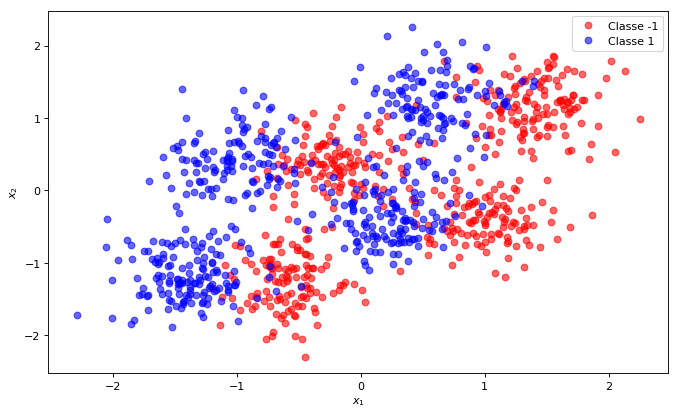

In [4]:
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.plot(data[0], data[1], 'o', alpha=.6)
plt.plot(data_class_1[0], data_class_1[1], 'ro', alpha=.6)
plt.plot(data_class_0[0], data_class_0[1], 'bo', alpha=.6)
plt.legend(('Classe -1','Classe 1'))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
#plt.grid(True, linestyle='--', linewidth=0.8)
plt.show()

### 3. _Holdout_ dos dados (Treinamento, Validação e Teste)

In [5]:
data_train_labels = data[2]
data_train = data.drop(2, axis=1)

data_val_labels = data_val[2]
data_val = data_val.drop(2, axis=1)

data_test_labels = data_test[2]
data_test = data_test.drop(2, axis=1)
print('Shape dados treinamento:', data_train.shape)
print('Shape dados validação:', data_val.shape)
print('Shape dados teste:', data_test.shape)
print('\nTreinamento\n',data_train.head())
print('\nValidação\n',data_val.head())
print('\nTeste\n', data_test.head())

Shape dados treinamento: (1000, 2)
Shape dados validação: (1000, 2)
Shape dados teste: (1000, 2)

Treinamento
           0         1
0  0.595256  0.000000
1  1.006073  0.595256
2  0.483975  1.006073
3 -0.394707  0.483975
4  1.166833 -0.394707

Validação
           0         1
0  0.652323  0.000000
1  1.295864  0.652323
2  1.009342  1.295864
3  1.048616  1.009342
4 -1.178718  1.048616

Teste
           0         1
0  0.276028  0.000000
1  1.032082  0.276028
2  0.868371  1.032082
3 -0.998403  0.868371
4 -1.583893 -0.998403


### 3. Progressão das funções custo em relação aos subconjuntos (Rede Neural MLP)

Para essa tarefa de classificação, foram utilizadas funções prontas do pacote _sickit-learn_. A rede neural foi construída com os seguintes critérios:

- Taxa de aprendizado: $\alpha = 0.01$
- Algoritmo de otimização: Adam, uma combinação entre RMSProp e SGD com _momentum_, onde utiliza os quadrados dos gradientes para escalar a taxa de aprendizado como RMSprop, e aproveita o momento usando a média móvel do gradiente em vez do próprio gradiente como SGD com _momentum_.
- Função de ativação: Retificadora $ReLU$
- Uma camada intermediária
- 20 Neurônios na camada intermediária

Além disso, as funções custo analisadas são funções de entropia cruzada.

C:\Users\Samuel\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


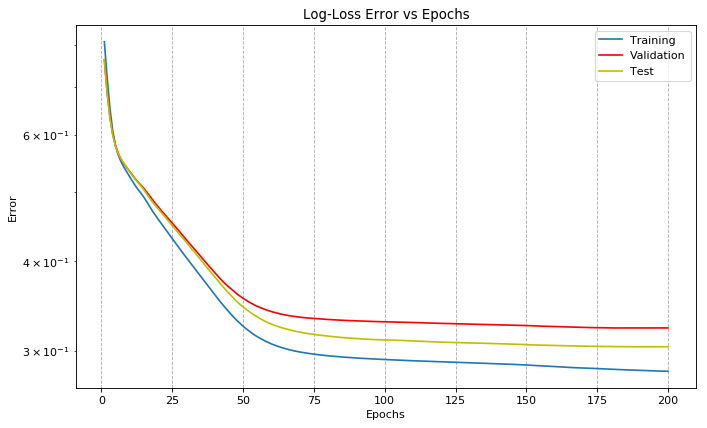

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

classifier = MLPClassifier(learning_rate_init=0.01, solver="adam", activation="relu", max_iter=1, 
                           verbose=False, random_state=42, warm_start=True)
classifier.hidden_layer_sizes = (20,)
epochs = 200

errors_train = []
errors_val = []
errors_test = []


for i in range(epochs):


    errors_train.append(classifier.fit(data_train, data_train_labels).loss_)
    
    y_val_predict = classifier.predict_proba(data_val)
    errors_val.append(log_loss(data_val_labels, y_val_predict))
    
    y_test_predict = classifier.predict_proba(data_test)
    errors_test.append(log_loss(data_test_labels, y_test_predict))
    
    
plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')    
plt.semilogy(range(1, epochs + 1), errors_train, '-')
plt.semilogy(range(1, epochs + 1), errors_val, '-r')
plt.semilogy(range(1, epochs + 1), errors_test, '-y')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend(('Training', 'Validation', 'Test'))
plt.grid(True, linestyle='--', linewidth=0.8)
plt.title('Log-Loss Error vs Epochs')
plt.show()


Observamos que o erro de validação é maior que o de treinamento, ficando mais evidente ao longo das épocas.

### 4. Regiões de decisão definidas pela rede MLP no espaço dos dados

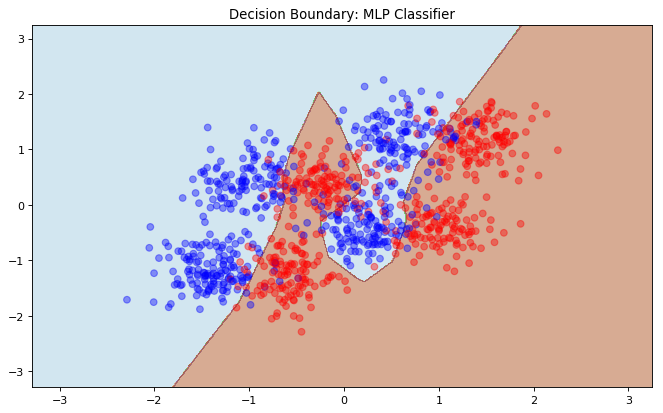

In [7]:
X = data_train.values
y = data_train_labels.values

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k') 
colormap = plt.cm.Paired
plt.contourf(xx, yy, Z, alpha=0.5, cmap=colormap)
color_map_samples = {-1: (0, 0, 1), 1: (1, 0, 0)}
colors = [color_map_samples[c] for c in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.4)
#plt.grid(True, linestyle='--', linewidth=0.8)
plt.title('Decision Boundary: MLP Classifier')
plt.show()



É importante notar que apesar da simples estrutura da rede, ja conseguimos ver notar uma semelhança das regiões de decisão correspondentes ao classificador ótimo (__MAP__).

### 5. Saída gerada da rede MLP junto ao conjunto de Teste

Para a rede projetada (uma camada intermediária com 10 neurônios e $\alpha = 0.01$), obtemos uma acurácia de 88%.


In [8]:
predictions = pd.DataFrame(classifier.predict(data_test))
predictions.columns = ['Predicted']
predictions['Real'] = data_test_labels.values


print('Accuracy:',classifier.score(data_test, data_test_labels))
print('Error:', 1 - classifier.score(data_test, data_test_labels))
print(predictions.head(10))

Accuracy: 0.883
Error: 0.11699999999999999
   Predicted  Real
0       -1.0   1.0
1        1.0   1.0
2       -1.0  -1.0
3       -1.0  -1.0
4       -1.0  -1.0
5        1.0   1.0
6        1.0   1.0
7        1.0  -1.0
8        1.0   1.0
9       -1.0  -1.0


### 6. Modificação do número de neurônios da rede MLP

Training Neural Net w/: 2 Hidden Neurons


C:\Users\Samuel\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training Neural Net w/: 10 Hidden Neurons


C:\Users\Samuel\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training Neural Net w/: 50 Hidden Neurons


C:\Users\Samuel\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training Neural Net w/: 100 Hidden Neurons


C:\Users\Samuel\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


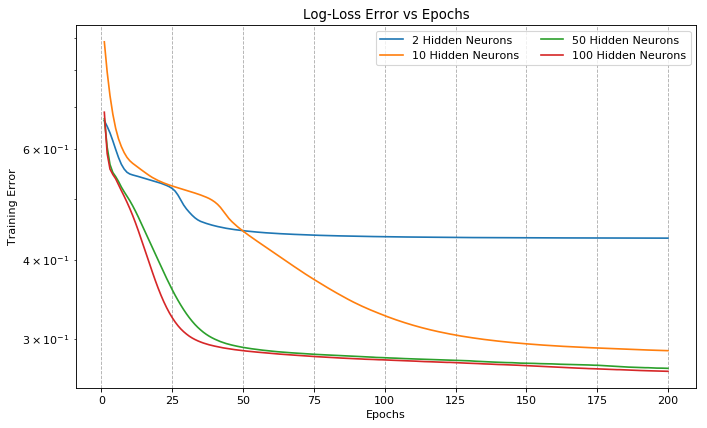

In [9]:
params = [{'hidden_layer_sizes': 2},
          {'hidden_layer_sizes': 10},
          {'hidden_layer_sizes': 50},
          {'hidden_layer_sizes': 100},]

labels = ["2 Hidden Neurons", "10 Hidden Neurons",
         "50 Hidden Neurons", "100 Hidden Neurons"]


plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')    
for label, param in zip(labels, params):
    print("Training Neural Net w/: %s" % label)
    mlp = MLPClassifier(learning_rate_init=0.01, solver="adam", activation="relu", max_iter=1, 
                           verbose=False, random_state=42, warm_start=True, **param)
    epochs = 200

    errors_train = []
    errors_val = []
    errors_test = []

    
    for i in range(epochs):
        errors_train.append(mlp.fit(data_train, data_train_labels).loss_)
    
        y_val_predict = mlp.predict_proba(data_val)
        errors_val.append(log_loss(data_val_labels, y_val_predict))
    
        y_test_predict = mlp.predict_proba(data_test)
        errors_test.append(log_loss(data_test_labels, y_test_predict))
        
    
    plt.semilogy(range(1, epochs + 1), errors_train, '-')
    plt.xlabel('Epochs')
    plt.ylabel('Training Error')
    
    plt.grid(True, linestyle='--', linewidth=0.8)
    plt.title('Log-Loss Error vs Epochs')

plt.legend(labels, ncol=2, loc="upper right")
plt.show()


Percebemos que, de fato, aumentando o número de neurônios tendemos a aumentar a complexidade do modelo, obtendo melhores acurácias. No entanto existe uma relação de _trade-off_, de forma que o acréscimo de neurônios faz com que o modelo seja mais custoso e tenha maiores dificuldades de __generalização__ (_overfitting_).

### 7. Regiões de decisão definidas por SVM

O classificador baseado por vetores suportes (SVM) foi construída com os seguintes critérios:

- Função kernel: Radial Basis Function (RBF) $K(x,x') = exp(-\gamma||x-x'||^2)$
- $\gamma = 0.001$, correspondendo a $\dfrac{1}{n_{features}}$
- Fator de regularização $C$ = 1

In [10]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='rbf', C = 1, gamma = 'auto')  
svclassifier.fit(data_train, data_train_labels)  


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

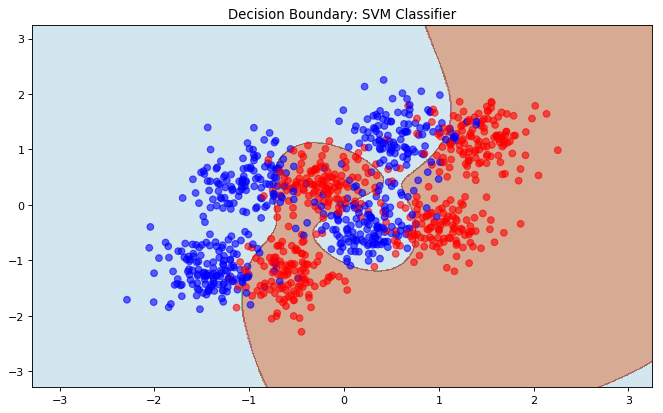

In [11]:
X = data_train.values
y = data_train_labels.values
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = svclassifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k') 
colormap = plt.cm.Paired
plt.contourf(xx, yy, Z, alpha=0.5, cmap=colormap)
color_map_samples = {-1: (0, 0, 1), 1: (1, 0, 0)}
colors = [color_map_samples[c] for c in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6)
plt.scatter(svclassifier.support_vectors_[:, 1],
                   svclassifier.support_vectors_[:, 0],
                   s=2, linewidth=1, facecolors='none');
plt.title('Decision Boundary: SVM Classifier')
plt.show()

Assim como no caso da rede MLP, essas regiões de decisão são semelhantes as do __MAP__.

### 8. Saída gerada da SVM junto ao conjunto de Teste

Para a SVM projetada (função de _Kernel_ RBF, $C = 1$), obtemos uma acurácia de 86%.

In [12]:
predictions = pd.DataFrame(svclassifier.predict(data_test))
predictions.columns = ['Predicted']
predictions['Real'] = data_test_labels.values


print('Accuracy:',svclassifier.score(data_test, data_test_labels))
print('Error:', 1 - svclassifier.score(data_test, data_test_labels))
print(predictions.head(10))

Accuracy: 0.866
Error: 0.134
   Predicted  Real
0       -1.0   1.0
1        1.0   1.0
2       -1.0  -1.0
3       -1.0  -1.0
4       -1.0  -1.0
5        1.0   1.0
6        1.0   1.0
7        1.0  -1.0
8        1.0   1.0
9       -1.0  -1.0


### 9. Explorando diferentes parametrizações (SVM)

Para seleção dos melhores parâmetros para o problema em questão, utilizaremos um tipo de seleção de modelos presente no pacote _scikit-learn_ denominado _GridSearchCV_. Para isto, consideraremos os seguintes:

- Função kernel: Radial Basis Function (RBF), Sigmóide e Linear.
- $\gamma = \{1, 0.1, 0.01, 0.001, 0.0001\}$
- Fator de regularização $C = \{0.1, 1, 10, 100\}$

In [13]:
from sklearn.model_selection import GridSearchCV
# Grid Search
# Parameter Grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf', 'sigmoid', 'linear']}
 
# Make grid search classifier
clf_grid = GridSearchCV(SVC(), param_grid, verbose=1)
 
# Train the classifier
clf_grid.fit(data_train, data_train_labels)
 
# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


C:\Users\Samuel\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Parameters:
 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Estimators:
 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    4.0s finished


Dessa forma, vemos que, dentre os testados, os melhores parâmetros foram:
- Kernel = RBF
- $\gamma = 1$
- $C = 1$

Agora plotaremos o gráfico com os parâmetros em questão, bem como sua acurácia:


Accuracy: 0.88
Error: 0.12


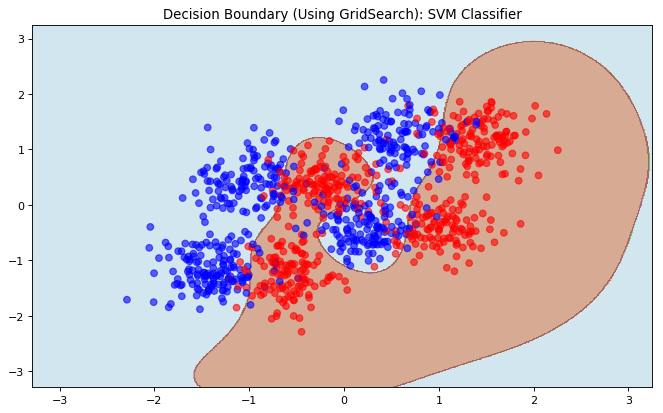

In [14]:
Z = clf_grid.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k') 
colormap = plt.cm.Paired
plt.contourf(xx, yy, Z, alpha=0.5, cmap=colormap)
color_map_samples = {-1: (0, 0, 1), 1: (1, 0, 0)}
colors = [color_map_samples[c] for c in y]
plt.scatter(X[:, 0], X[:, 1], c=colors, alpha=0.6)

plt.title('Decision Boundary (Using GridSearch): SVM Classifier')

print('Accuracy:',clf_grid.score(data_test, data_test_labels))
print('Error:', 1 - clf_grid.score(data_test, data_test_labels))
plt.show()

O parâmetro $C$ informa à otimização do SVM quanto você deseja evitar classificar erroneamente cada exemplo de treinamento. Para valores grandes de $C$, a otimização escolherá um hiperplano de margem menor se esse hiperplano fizer um trabalho melhor ao classificar todos os pontos de treinamento corretamente. Por outro lado, um valor muito pequeno de $C$ fará com que o otimizador procure por um hiperplano de separação de margem maior, mesmo se esse hiperplano classificar incorretamente mais pontos. Já $\gamma$ define quanta influência tem um único exemplo de treinamento. Quanto maior $\gamma$, mais próximos outros exemplos devem ser afetados.
Além disso, percebemos que, de fato, houve melhoras na acurácia do modelo.